<a href="https://colab.research.google.com/github/Subhasmitamishra88/BIG-DATA-SPARK-NOSQL/blob/main/BDSN_Assignment_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt update > /dev/null
!apt install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# Get latest and correct version of Spark
#
# if the current version of Spark is not used, there may be errors
# check here for current versions http://apache.osuosl.org/spark
#
#!wget -q http://apache.osuosl.org/spark/spark-2.2.2/spark-2.2.2-bin-hadoop2.7.tgz
#!wget -q http://apache.osuosl.org/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
#!wget -q http://apache.osuosl.org/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
#!wget -q http://apache.osuosl.org/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
#!wget -q http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
#!wget -q http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!wget -q http://apache.osuosl.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz

#!tar xf spark-2.4.5-bin-hadoop2.7.tgz
#!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
#!pip install -q findspark
!pip install -q pyspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
#os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"
#os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
#os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

     |████████████████████████████████| 281.4 MB 38 kB/s 
     |████████████████████████████████| 198 kB 51.5 MB/s 


In [ ]:
from pyspark.sql import SparkSession
#spark = SparkSession.builder.master("local[*]").getOrCreate()
# note UI port switched from default 4040 to 4050 to avoid clash with ngrok
spark = SparkSession.builder.master("local[*]").config('spark.ui.port', '4050').getOrCreate()
sc = spark.sparkContext

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MLlibLRProject').getOrCreate()

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving customer_churn.csv to customer_churn.csv


In [ ]:
data = spark.read.csv('customer_churn.csv', header = True, inferSchema=True)

In [ ]:
data.head(1)

[Row(customerID='7590-VHVEG', gender='Female', SeniorCitizen=0, Partner='Yes', Dependents='No', tenure=1, PhoneService='No', MultipleLines='No phone service', InternetService='DSL', OnlineSecurity='No', OnlineBackup='Yes', DeviceProtection='No', TechSupport='No', StreamingTV='No', StreamingMovies='No', Contract='Month-to-month', PaperlessBilling='Yes', PaymentMethod='Electronic check', MonthlyCharges=29.85, TotalCharges='29.85', Churn='No')]

In [ ]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [ ]:
#Count null/nan values for all columns:
from pyspark.sql.functions import isnan, isnull, when, count, col

data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).show()
data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [ ]:
df = data.groupby('InternetService').count()
df.filter(df['count']>2).show()

+---------------+-----+
|InternetService|count|
+---------------+-----+
|    Fiber optic| 3096|
|             No| 1526|
|            DSL| 2421|
+---------------+-----+



In [ ]:
df = data.groupby('Partner').count()
df.filter(df['count']>1).show()

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+



In [ ]:
data.describe().select('customerID','gender','SeniorCitizen','Partner',
                       'Dependents','tenure','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges','Churn',).show()

+----------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|customerID|gender|     SeniorCitizen|Partner|Dependents|            tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|    MonthlyCharges|      TotalCharges|Churn|
+----------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|      7043|  7043|              7043|   7043|      7043|              7043|        7043|         7043|           7043|          7043|        704

In [ ]:
data.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



In [ ]:
from pyspark.sql.functions import when

ratio = 0.2
def weightBalance(label):
    return when(label == 1, 1-ratio).otherwise(ratio)

data = data.withColumn('tenure', weightBalance(data['Churn']))


In [ ]:
data.describe().show

<bound method DataFrame.show of DataFrame[summary: string, customerID: string, gender: string, SeniorCitizen: string, Partner: string, Dependents: string, tenure: string, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: string, TotalCharges: string, Churn: string]>

In [ ]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, isnan, split, udf, isnull, first, col, format_number, rand, countDistinct,count, trim, desc, countDistinct, expr, min, max
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import sum as fsum
from pyspark.sql.types import IntegerType, FloatType, StringType

import pyspark.sql.functions as f

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler, Normalizer, MinMaxScaler, VectorAssembler, HashingTF
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

In [ ]:
# Read json data
from google.colab import files
uploaded=files.upload()

Saving mini_sparkify_event_data.json to mini_sparkify_event_data.json


In [ ]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

In [ ]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [ ]:
# Select and show statistcs for several items 
for col in df.schema:    
    if str(col.name) in ['artist','auth','gender','level' ,'location','method','page']:
        df.groupBy(str(col.name)).count().show() # Understand the meaning of columns

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|      The Black Keys| 1125|
|         Silverstein|   60|
|           Kate Nash|   99|
|        Yann Tiersen|  139|
|    Jane's Addiction|   68|
|          Tim Hughes|   39|
|          Carl Craig|    3|
|Dashboard Confess...|   98|
|Yonder Mountain S...|   63|
|           Los Lobos|   45|
|Pete Rock & C.L. ...|    2|
|        Ziggy Marley|   28|
|      Jarabe De Palo|   83|
|               Rufio|   13|
|WC And The Maad C...|    1|
|      Jorge Gonzalez|   24|
|                Silk|   22|
|  The Watts Prophets|    6|
|            La Shica|    2|
|        Generation X|   19|
+--------------------+-----+
only showing top 20 rows

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+

+---

In [ ]:
# Check for null values 
for i in df.columns:
    print(i, ':', df.filter(df[i].isNull()).count())

artist : 58392
auth : 0
firstName : 8346
gender : 8346
itemInSession : 0
lastName : 8346
length : 58392
level : 0
location : 8346
method : 0
page : 0
registration : 8346
sessionId : 0
song : 58392
status : 0
ts : 0
userAgent : 8346
userId : 0


In [ ]:
# Total sessions after removing duplicates based on user and session id
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [ ]:
# Total number of sessions after removing blank user id 
df = df.filter(df["userId"] != "")
df.count()

278154

In [ ]:
# Number of unique users in dataset
user_ids = df.select('userId').dropDuplicates().count()
print('The number of unique users in dataset: ' + str(user_ids))

# Number of unique session ids
session_ids = df.select('sessionId').dropDuplicates().count()
print('The number of unique session ids: ' + str(session_ids))

# Number of unique pages
pages = df.select('page').dropDuplicates().count()
print('The number of unique pages: ' + str(pages))

The number of unique users in dataset: 225
The number of unique session ids: 2312
The number of unique pages: 19


In [ ]:
# Churn Definition (1 = cancel, 0 = paid)
churn_def = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# Apply to the dataframe
df = df.withColumn("churn", churn_def("page"))
# Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("churn", fsum("churn").over(windowval))

In [ ]:
# Create a user defined function for formating the timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour)
# Apply the udf on the ts column
df = df.withColumn("hour", get_hour(df.ts))
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='12')

In [ ]:
df_pandas = df.toPandas()
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,hour
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,12
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,13
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,13
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Thumbs Up,1538016340000,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,13
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,13


In [ ]:
# Count number of songs played in hour
songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))
# Create pandas for songs played in hour
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.head()

,hour,count
0,0,9062
1,1,8388
2,2,8336
3,3,8355
4,4,8147


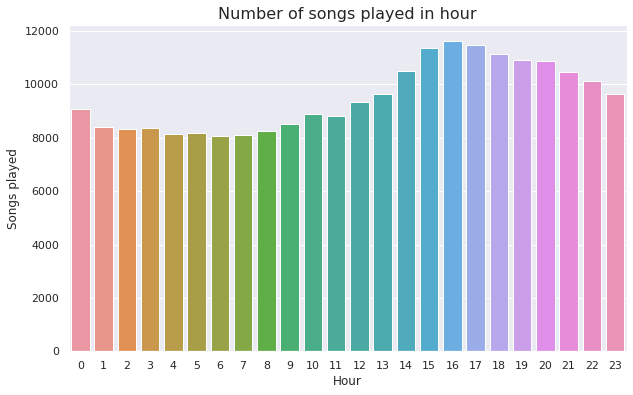

In [ ]:
# Songs played in hour
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.title("Number of songs played in hour", fontsize= 16)
sns.barplot(x="hour", y="count", data= songs_in_hour_pd)
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [ ]:
# Churn per gender
print('Churn per gender')
df.filter(df.page == 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().show()

print('Non-churn per gender')
df.filter(df.page != 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().show()

Churn per gender
+------+-----+
|gender|count|
+------+-----+
|     F|   20|
|     M|   32|
+------+-----+

Non-churn per gender
+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



In [ ]:
# Churn per gender plot
churn_gender_pd = df.filter(df.page == 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().toPandas()
churn_gender_pd['Churn'] = True
nonchurn_gender_pd = df.filter(df.page != 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().toPandas()
nonchurn_gender_pd['Churn'] = False
churn_gender = pd.concat([churn_gender_pd, nonchurn_gender_pd], sort=False, ignore_index=True)
churn_gender.head()

,gender,count,Churn
0,F,20,True
1,M,32,True
2,F,104,False
3,M,121,False


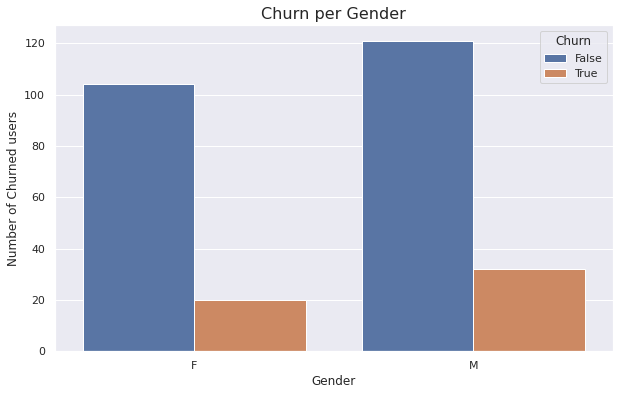

In [ ]:
# Plot churn per gender
plt.figure(figsize=(10, 6))
plt.title('Churn per Gender', fontsize=16)
sns.barplot(x='gender', y='count', hue='Churn', data=churn_gender)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Churned users', fontsize=12)
plt.show()

In [ ]:
# All user activity types
pages = df.groupby('page').count().sort('count', ascending=False)
pages.show()
pages_df = pages.toPandas()

activity = pages_df['page']
count = pages_df['count']

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



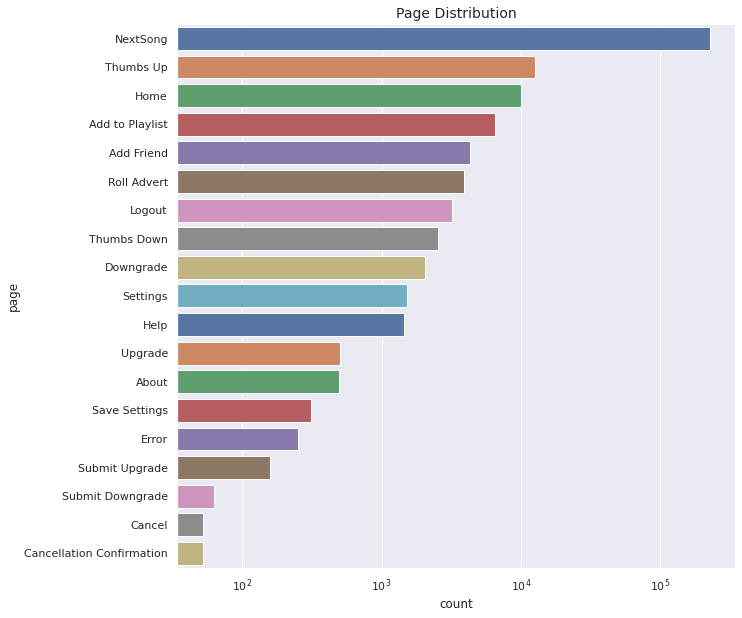

In [ ]:
current_palette = sns.color_palette()
plt.figure(figsize=(10, 10))

sns.barplot(x=count,
            y=activity,
            log=True,
            palette=current_palette)
plt.title("Page Distribution", fontsize=14);

In [ ]:
# Create a temporary view to perform SQL operations
df.createOrReplaceTempView("df_sqlsparkify")

In [ ]:
page_churn_df = spark.sql("""
                    SELECT page,
                           churn,
                           COUNT(DISTINCT(userId)) AS total_user
                    FROM   df_sqlsparkify
                    GROUP BY page,
                             churn
                    """).toPandas()

In [ ]:
page_churn_df.head()

,page,churn,total_user
0,Settings,0,152
1,Thumbs Down,1,48
2,Thumbs Up,1,50
3,Add to Playlist,1,50
4,Error,1,22


In [ ]:
def sns_barplot_text(x, y, data, title, hue=None, percentage=True, text=True,
                     log=False, figsize=(8, 5)):
    """
    Similar to sns.barplot but added text option for the bar
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=x, y=y, data=data, hue=hue, ax=ax, log=log)
    ax.set_xlabel(f"{data.columns[0]}")
    ax.set_title(title)
    ax.set_xticklabels(data.loc[:,x].unique(), rotation=90)
    if text:
        for p in ax.patches:
                height = p.get_height()
                if percentage:
                    ax.text(p.get_x() + p.get_width() / 2.,
                            height,
                            f"{height /data.loc[:,y].sum() * 100 :.2f}%",
                            ha="center", fontsize=8)
                else:
                    ax.text(p.get_x() + p.get_width() / 2.,
                            height,
                            f"{height :.2f}",
                            ha="center", fontsize=8)

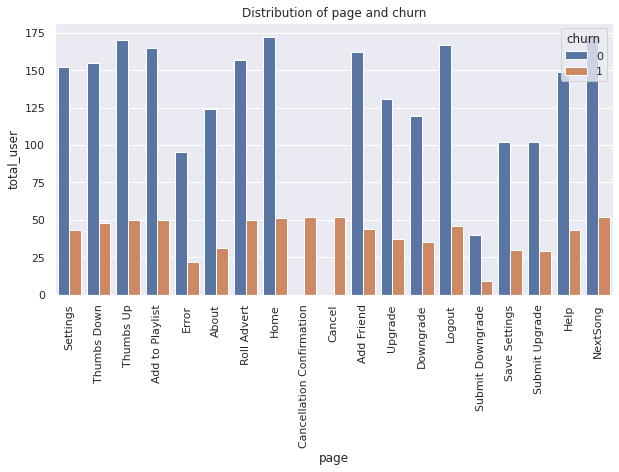

In [ ]:
sns_barplot_text(x="page", y="total_user", data=page_churn_df, hue="churn",
                 title="Distribution of page and churn", percentage=False,
                 text=False, figsize=(10, 5))

In [ ]:
# Create DataFrame for total user in location
location_df = spark.sql("""
                           SELECT location, 
                                  Count(DISTINCT userid) AS total_user 
                           FROM   df_sqlsparkify
                           GROUP  BY location 
                           ORDER BY total_user
                           DESC
                           """).toPandas()

In [ ]:
# Create DataFrame for churn user in location
location_churn_df = spark.sql("""
                                 SELECT location, 
                                        Count(DISTINCT userid) AS churn_user 
                                 FROM   df_sqlsparkify
                                 WHERE  churn=1
                                 GROUP BY location
                                 """).toPandas()

In [ ]:
# Merge DataFrame and add percentage column
merge_df = location_churn_df.merge(location_df, on="location").sort_values(by="total_user", ascending=False)
merge_df["percentage"] = merge_df["churn_user"] / merge_df["total_user"] * 100
merge_df.sort_values(by="percentage", ascending=False).head(20)

,location,churn_user,total_user,percentage
38,"Flint, MI",2,2,100.0
18,"Oxnard-Thousand Oaks-Ventura, CA",1,1,100.0
29,"Quincy, IL-MO",1,1,100.0
0,"Cleveland-Elyria, OH",1,1,100.0
20,"Monroe, LA",1,1,100.0
27,"North Wilkesboro, NC",1,1,100.0
23,"Bozeman, MT",1,1,100.0
21,"Little Rock-North Little Rock-Conway, AR",1,1,100.0
17,"Memphis, TN-MS-AR",1,1,100.0
32,"Lexington-Fayette, KY",1,1,100.0


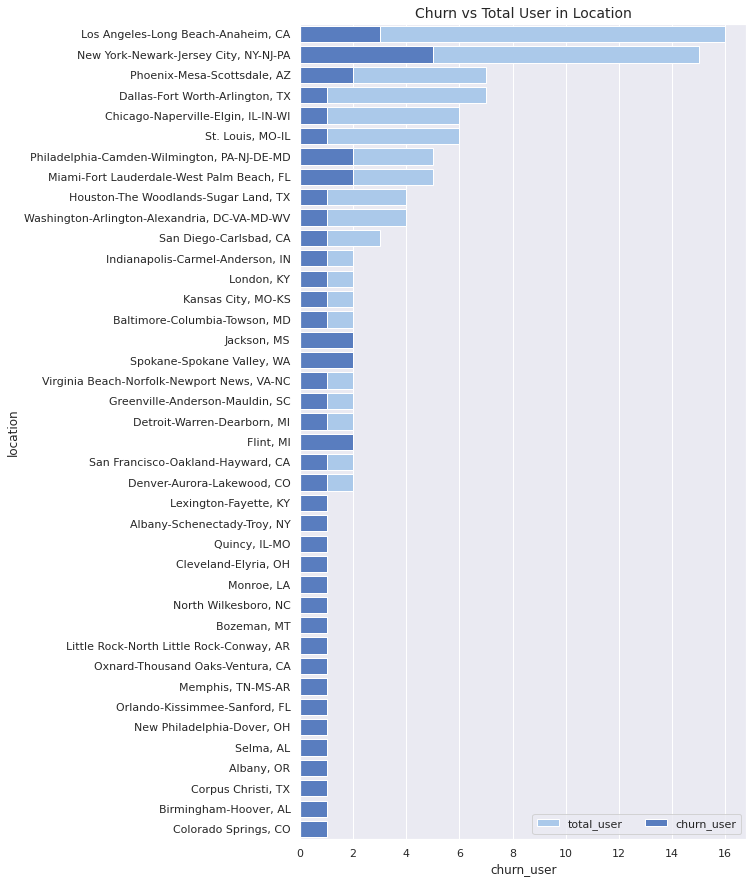

In [ ]:
fig, ax = plt.subplots(figsize=(8, 15))
plt.title("Churn vs Total User in Location", fontsize=14)
sns.set_color_codes("pastel")
sns.barplot(x="total_user", y="location", data=merge_df, ax=ax,
            label="total_user",color="b")

sns.set_color_codes("muted")
sns.barplot(x="churn_user", y="location", data=merge_df, ax=ax, 
            label="churn_user",color="b")
ax.legend(ncol=2, loc="lower right", frameon=True)

In [ ]:
# Load small subset for feature engineering
df = spark.read.json('mini_sparkify_event_data.json')

# Drop rows with missing user id
df = df.where(df.userId != '')

In [ ]:
# Create Feature
avg_session_duration = df.select(['userId','sessionId','ts']).groupby(['userId','sessionId']).agg(avg('ts').alias('avg_session_duration'))
avg_session_duration = avg_session_duration.drop('sessionId')
avg_session_duration.show(5)

+------+--------------------+
|userId|avg_session_duration|
+------+--------------------+
|    92|1.538592785972602...|
|    42|1.538685408666666...|
|   101|1.539165263256140...|
|   120|1.539209327272030...|
|   140|1.539424855166666...|
+------+--------------------+
only showing top 5 rows



In [ ]:
# User definded function
get_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# Create feature
churn = df.withColumn('churn', get_churn('page')).select(['userId','churn']).groupby('userId').agg(max('churn').alias('churn'))
# Validation
print('Number of rows: ' + str(churn.count()))
churn.show(5)

Number of rows: 225
+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|    51|    1|
|   124|    0|
+------+-----+
only showing top 5 rows



In [ ]:
# User definded function
get_gender = udf(lambda x: 1 if x == 'M' else 0, IntegerType())

# Create feature
gender = df.withColumn('gender', get_gender('gender')).select(['userId','gender']).groupby('userId').agg(max('gender').alias('gender'))

# Validation
print('Number of rows: ' + str(gender.count()))
gender.show(5)

Number of rows: 225
+------+------+
|userId|gender|
+------+------+
|100010|     0|
|200002|     1|
|   125|     1|
|    51|     1|
|   124|     0|
+------+------+
only showing top 5 rows



In [ ]:
# Create feature for total time 
length = df.select("userId", 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'total_time')

print('Number of rows: ' + str(length.count()))
length.show(5)

Number of rows: 225
+------+------------------+
|userId|        total_time|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899992|
+------+------------------+
only showing top 5 rows



In [ ]:
# User definded function
get_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())

# Create feature
level = df.select(['userId', 'level', 'ts']).orderBy(desc('ts')).dropDuplicates(['userId']).select(['userId', 'level'])\
        .withColumn('level', get_level('level').cast(IntegerType()))

# Validation
print('Number of rows: ' + str(level.count()))
level.show(5)

Number of rows: 225
+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
|   125|    0|
|   124|    1|
|    51|    1|
+------+-----+
only showing top 5 rows



In [ ]:
# Create feature
df_reg_ts = df.select(['userId','registration']).groupby('userId').agg(min('registration').alias('reg_ts'))
df_max_ts = df.select(['userId','ts']).groupby('userId').agg(max('ts').alias('max_ts'))
time_since_reg = df_max_ts.join(df_reg_ts, on=['userId'])

# Calculate Delta
time_since_reg = time_since_reg.withColumn('time_since_reg', expr('max_ts - reg_ts'))
time_since_reg = time_since_reg.drop('max_ts')
time_since_reg = time_since_reg.drop('reg_ts')

# Validation
print('Number of rows: ' + str(time_since_reg.count()))
time_since_reg.show(5)

Number of rows: 225
+------+--------------+
|userId|time_since_reg|
+------+--------------+
|100010|    4807612000|
|200002|    6054448000|
|   125|    6161779000|
|   124|   11366431000|
|    51|    1680985000|
+------+--------------+
only showing top 5 rows



In [ ]:
df = churn.join(avg_session_duration, ['userId'])\
          .join(gender, ['userId'])\
          .join(length, ['userId'])\
          .join(level, ['userId'])\
          .join(time_since_reg, ['userId'])

In [ ]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- avg_session_duration: double (nullable = true)
 |-- gender: integer (nullable = true)
 |-- total_time: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- time_since_reg: long (nullable = true)



In [ ]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- avg_session_duration: double (nullable = true)
 |-- gender: integer (nullable = true)
 |-- total_time: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- time_since_reg: long (nullable = true)



In [ ]:
print((df.count(), len(df.columns)))

(3176, 7)


In [ ]:
user_df = df.drop('userId')
#user_df.write.save("user_df.csv",format = "csv",header = True)
features = [col for col in user_df.columns if col!='churn'] 
train, test = user_df.randomSplit([0.7, 0.3], seed=42)
train = train.cache()

In [ ]:
def model_pipeline(classifier, params):
    """
    Build model pipline 
    input:
    classifier: type of classifier
    params: param grid
    output :
    ML pipeline model
    """
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=params,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=5,
    )
    return model

In [ ]:
# logistic regression 
m1 = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
m1_param = ParamGridBuilder().build()
model_lr = model_pipeline(m1, m1_param)

In [ ]:
fit_model_lr = model_lr.fit(train)

In [ ]:
pred_lr = fit_model_lr.transform(test)

In [ ]:
pred_lr.select("prediction").dropDuplicates().collect()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
f1_score = evaluator.evaluate(pred_lr, {evaluator.metricName: "f1"})
print("f1 using Logistic Regression: {}".format(f1_score))

f1 using Logistic Regression: 0.8224476963180299


In [ ]:
#random forest
m2 = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn")
m2_param = ParamGridBuilder().build()
model_rf = model_pipeline(m2, m2_param)

In [ ]:
fit_model_rf = model_rf.fit(train)

In [ ]:
pred_rf = fit_model_rf.transform(test)

In [ ]:
f1_score_rf = evaluator.evaluate(pred_rf, {evaluator.metricName: "f1"})
print("f1 using Random Forest: {}".format(f1_score_rf))

f1 using Random Forest: 0.9086622176765413


In [ ]:
# gradient boost
gbt =GBTClassifier(featuresCol="scaled_features", labelCol="churn")
gbt_param = ParamGridBuilder().build()
gbt_model = model_pipeline(gbt, gbt_param)

In [ ]:
gbt_fit_model = gbt_model.fit(train)
gbt_pred = gbt_fit_model.transform(test)
gbt_pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [ ]:
gbt_f1_score = evaluator.evaluate(gbt_pred, {evaluator.metricName: "f1"})
print("f1 using Gradient Boosting: {}".format(gbt_f1_score))

f1 using Gradient Boosting: 0.9533346236051621


In [ ]:
# Decision Tree
dt =DecisionTreeClassifier(featuresCol="scaled_features", labelCol="churn")
dt_param = ParamGridBuilder().build()
dt_model = model_pipeline(dt, dt_param)

In [ ]:
dt_fit_model = dt_model.fit(train)
dt_pred = dt_fit_model.transform(test)

In [ ]:
dt_pred.select("prediction").dropDuplicates().collect()
dt_f1_score = evaluator.evaluate(dt_pred, {evaluator.metricName: "f1"})
print("f1 using Gradient Boosting: {}".format(dt_f1_score))

f1 using Gradient Boosting: 0.9194034040706962


In [ ]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
paramGrid_lr = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .build()
model_tuned = model_pipeline(lr, paramGrid_lr)

In [ ]:
fit_model_tuned = model_tuned.fit(train)                                       
best_model = fit_model_tuned.bestModel
best_model_pred = best_model.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
best_f1_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "f1"})
print("f1 using tuned RF: {}".format(best_f1_score))

f1 using tuned RF: 0.8026701665733695


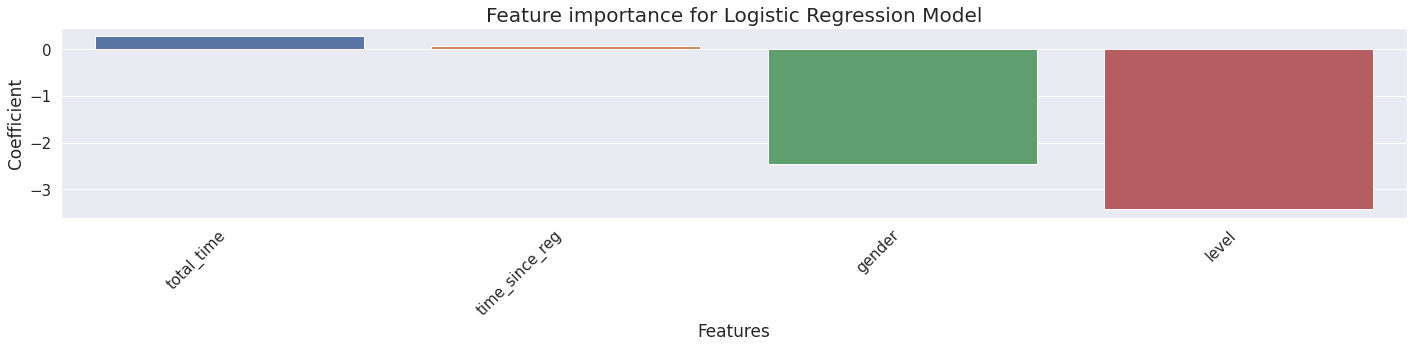

In [ ]:
def plot_feature_importance(model, feature_cols):
    """
    Plot bar chart showing the importance of features with logistic regression model. 
    """
       
    feature_coef = model.bestModel.stages[2].coefficients.values.tolist()
    feature_coef_df = pd.DataFrame(list(zip(feature_cols, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(20,5))
    sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
    plt.title('Feature importance for Logistic Regression Model', fontsize=20)
    plt.xlabel('Features', fontsize=17)
    plt.ylabel('Coefficient', fontsize=17)
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()

plot_feature_importance(fit_model_tuned, user_df.columns[2:])

In [ ]:
feat_cols = ['total_artist', 'gender', 'level', 'num_downgrade', 'num_advert', 'num_song_playlist',
     'num_thumbs_down', 'num_thumbs_up', 'num_friend', 'total_length', 'num_song',
     'session', 'avg_songs', 'avg_daily_sessions', 'avg_monthly_sessions', 'os',
     'browser', 'browser_ver']